# Experiment with the files to properly extract metadata from the files

In [1]:
import matplotlib.pyplot as plt
from collections import Counter
import binascii
import os
from pathlib import Path
import numpy as np
import time
import json

Metadata associated with the file: 
File extension:  .csv
File name:  CDIACPub8/PX100E
File path:  /home/matthewchen/MetaDataExtractionModel/CDIACPub8/PX100E.csv
File size is:  706892 bytes
Parent Directory:  /home/matthewchen/MetaDataExtractionModel/CDIACPub8
Here is a list of the 10 most frequent bytes: 
0x2c: 122889
0x30: 91654
0x39: 90350
0x2e: 79622
0x31: 56593
0x33: 46551
0x32: 40035
0x37: 31256
0x34: 29870
0x38: 27688
[44. 48. 57. 46. 49. 51. 50. 55. 52. 56.]


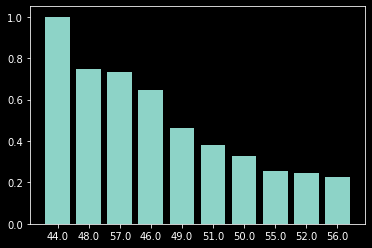

In [2]:
"""

Basic clustering of CDIAC data files from Globus

"""


file_path = "CDIACPub8/PX100E.csv"
#test file path and experiment with a .tsv file 
# feel free to change because this is my machine specific

f = open(file_path, "rb")
contents = f.read()
c = Counter(contents)

print("Metadata associated with the file: ")

split_tuple = os.path.splitext(file_path)
print("File extension: ", split_tuple[1])
print("File name: ", split_tuple[0])
print("File path: ", os.path.abspath(file_path))
print("File size is: ", os.path.getsize(file_path), "bytes")
print("Parent Directory: ", os.path.dirname(os.path.abspath(file_path)))


number_of_occurences = 10
print("Here is a list of the {num_occ} most frequent bytes: ".format(num_occ=number_of_occurences))

data = np.zeros(number_of_occurences)
values = np.zeros(number_of_occurences)

i = 0
for value, frequency in c.most_common(number_of_occurences):
        data[i] = frequency
        values[i] = value
        i += 1
        print("0x{:02x}: {}".format(value, frequency))

data = data / np.amax(data)

print(values)
plt.bar(range(len(values)), data, align='center', tick_label=values)
plt.show()

## I hope this doesn't crash my computer but I'm going to open each file

In [2]:
rootdir = "../CDIACPub8"

file_count = 0
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        file_count += 1
print("File count: {fc}".format(fc=file_count))

File count: 20427


Cannot read all 20426 files so we will first analyze time latency of going through 4kb, 8kb, 16kb, 32kb, 64kb, 128kb, 256kb, and 512kb head of first 500 files

In [18]:
def analyze_byte_head_time(chunksize, num_from_head=500):
    start = time.time()
    file_index = 0
    for subdir, dirs, files in os.walk(rootdir):
        for file_name in files:
            filepath = subdir + os.sep + file_name

            f = open(filepath, "rb")
            contents = f.read(chunksize)
            counter = Counter(contents)
            f.close()

            file_index += 1
            if file_index == 500:
                break
         if file_index == 500:
                break


    end = time.time()
    time_elapsed = end - start
    print("For chunksize: {cs} Time elapsed was: {te} seconds".format(cs=chunksize, te=time_elapsed))
    return time_elapsed

For chunksize: 4096 Time elapsed was: 0.029580116271972656 seconds
For chunksize: 8192 Time elapsed was: 0.03571295738220215 seconds
For chunksize: 16384 Time elapsed was: 0.0634911060333252 seconds
For chunksize: 32768 Time elapsed was: 0.14056086540222168 seconds
For chunksize: 65536 Time elapsed was: 0.267291784286499 seconds
For chunksize: 131072 Time elapsed was: 0.45305657386779785 seconds
For chunksize: 262144 Time elapsed was: 0.9217715263366699 seconds
For chunksize: 524288 Time elapsed was: 1.674588680267334 seconds
For chunksize: 1048576 Time elapsed was: 3.028841257095337 seconds
For chunksize: 2097152 Time elapsed was: 5.458996772766113 seconds


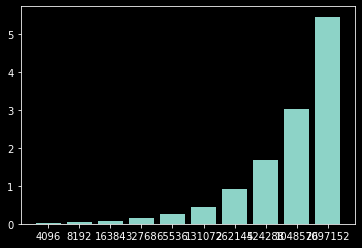

In [14]:
times = []
head_size = []

for i in range(0, 10):
    head_size.append(4096 * (2 ** i))  
    times.append(analyze_byte_head_time(head_size[i]))

plt.figure(1)
plt.bar(range(len(head_size)), times, align='center', tick_label=head_size)
plt.show()

In [10]:

def analyze_bytes(chunksize, file_count):
    mega_dict = dict()
    start = time.time()
    file_index = 0
    for subdir, dirs, files in os.walk(rootdir):
        for file_name in files:
            filepath = os.path.abspath(os.path.join(subdir, file_name))
            file_dict = dict()
            f = open(filepath, "rb")
            contents = f.read(chunksize)
            counter = Counter(contents)

            for value, frequency in counter.most_common(255):
                file_dict[value] = frequency

            f.close()

            mega_dict[filepath] = file_dict

            file_index += 1
            if file_index % 2000 == 0:
                print('done with 2000')

    end = time.time()
    time_elapsed = end - start
    print("For chunksize: {cs} bytes Time elapsed was: {te} seconds".format(cs=chunksize, te=time_elapsed))
    return mega_dict
   

In [14]:
one_gram_mega_dict = analyze_bytes(262144, file_count)
with open('one_grams_256.json', 'w+') as f1:
    json.dump(one_gram_mega_dict, f1, indent=4)
    f1.close()
print("Dumping done!")


done with 2000
done with 2000
done with 2000
done with 2000
done with 2000
done with 2000
done with 2000
done with 2000
done with 2000
done with 2000
For chunksize: 262144 bytes Time elapsed was: 68.88771438598633 seconds
Dumping done!


In [20]:
print(file_count)

20426


# 2 gram extraction

In [12]:
def extract_2grams(chunksize):
    start = time.time()
    file_index = 0
    mega_dict = dict()

    for subdir, dirs, files in os.walk(rootdir):
        for file_name in files:
            file_dict = dict()
            file_path = os.path.abspath(os.path.join(subdir, file_name))
            f = open(file_path, "rb")
            contents = f.read(chunksize)
            contents_byte_array = bytearray(contents)

            for i in range(len(contents_byte_array)):
                if i == len(contents_byte_array) - 1:
                    continue
                curr_byte = hex(contents_byte_array[i])
                next_byte = hex(contents_byte_array[i+1])
                key = str(curr_byte) + '-' + str(next_byte)
                if key in file_dict:
                    file_dict[key] += 1
                else:
                    file_dict[key] = 1

            if file_index % 2000 == 0:
                print("Done with 2000")
            file_index += 1    
            mega_dict[file_path] = file_dict
    
    
    end = time.time()
    time_elapsed = end - start
    print("For chunksize: {cs} bytes Time elapsed was: {te} seconds".format(cs=chunksize,te=time_elapsed))
    return mega_dict

   

In [15]:
mega_dict_2_gram = (extract_2grams(262144))
with open('two_grams_512.json', 'w+') as f1:
    json.dump(mega_dict_2_gram, f1, indent=4)
    f1.close()
print("Dumping done!")

Done with 2000
Done with 2000
Done with 2000
Done with 2000
Done with 2000
Done with 2000
Done with 2000
Done with 2000
Done with 2000
Done with 2000
Done with 2000
For chunksize: 262144 bytes Time elapsed was: 1207.1123533248901 seconds
Dumping done!


# 3 gram extraction

In [40]:
def extract_3grams(chunksize):
    start = time.time()
    file_index = 0
    mega_dict = dict()

    for subdir, dirs, files in os.walk(rootdir):
        for file_name in files:
            file_dict = dict()
            file_path = os.path.join(subdir, file_name)
            f = open(file_path, "rb")
            contents = f.read(chunksize)
            contents_byte_array = bytearray(contents)

            for i in range(len(contents_byte_array)):
                if i >= len(contents_byte_array) - 2:
                    continue
                curr_byte = hex(contents_byte_array[i])
                next_byte = hex(contents_byte_array[i+1])
                next_next_byte = hex(contents_byte_array[i+2])
                key = str(curr_byte) + '-' + str(next_byte) + '-' + str(next_next_byte)
                if key in file_dict:
                    file_dict[key] += 1
                else:
                    file_dict[key] = 1

            if file_index % 1000 == 0:
                print("Done with 1000")
            file_index += 1    
            mega_dict[file_path] = file_dict
    
    
    end = time.time()
    time_elapsed = end - start
    print("For chunksize: {cs} bytes Time elapsed was: {te} seconds".format(cs=chunksize,te=time_elapsed))
    return mega_dict

In [41]:
mega_dict_3_gram = (extract_3grams(1048576))
with open('3_grams.json', 'w+') as f2:
    print('Starting dump...')
    json.dump(mega_dict_3_gram, f2, indent=4)
    f2.close()

print('Done with dump :)')


Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
Done with 1000
For chunksize: 1048576 bytes Time elapsed was: 3643.4144489765167 seconds
Starting dump...
Done with dump :)


In [10]:
def extract_gram_test(chunksize):
    start = time.time()
    mega_dict = dict()
    file_dict = dict()
    file_path = "test.txt"
    f = open(file_path, "rb")
    contents = f.read(chunksize)
    contents_byte_array = bytearray(contents)

    for i in range(len(contents_byte_array)):
        if i == len(contents_byte_array) - 1:
            continue
        curr_byte = hex(contents_byte_array[i])
        next_byte = hex(contents_byte_array[i+1])
        key = str(curr_byte) + '-' + str(next_byte)
        if key in file_dict:
            file_dict[key] += 1
        else:
            file_dict[key] = 1
         
    mega_dict[file_path] = file_dict
    
    end = time.time()
    time_elapsed = end - start
    print("For chunksize: {cs} bytes Time elapsed was: {te} seconds".format(cs=chunksize,te=time_elapsed))
    return mega_dict


In [11]:
dict_2_gram = (extract_gram_test(1048576))
with open('test.json', 'w+') as f3:
    print('Starting dump...')
    json.dump(dict_2_gram, f3, indent=4)
    f3.close()
    print("Dump done!")

For chunksize: 1048576 bytes Time elapsed was: 0.014586210250854492 seconds
Starting dump...
Dump done!
